In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=10)
client = Client(cluster)
client

/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://134.246.146.72/3389/1 Dashboard: http://134.246.146.72/3389/1:46685/status,Cluster Workers: 1 Cores: 10 Memory: 67.17 GB


In [3]:
def _adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

In [4]:
def xgcm_grid(ds):
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds
    

In [5]:
# Ajout des coordonnées au DataArray
def add_coords(ds, var, coords):
    for co in coords:
        var.coords[co] = ds.coords[co]



# passage du DataArray du point rho au point u sur la grille C
def rho2u(v, ds):
    """
    interpolate horizontally variable from rho to u point
    """
    grid = ds.attrs['xgcm-Grid']
    var = grid.interp(v,'xi')
    add_coords(ds, var, ['xi_u','eta_u'])
    var.attrs = v.attrs
    return var.rename(v.name)

# passage du DataArray du point u au point rho sur la grille C
def u2rho(v, ds):
    """
    interpolate horizontally variable from u to rho point
    """
    grid = ds.attrs['xgcm-Grid']
    var = grid.interp(v,'xi')
    add_coords(ds, var, ['xi_rho','eta_rho'])
    var.attrs = v.attrs
    return var.rename(v.name)

# passage du DataArray du point v au point rho sur la grille C
def v2rho(v, ds):
    """
    interpolate horizontally variable from rho to v point
    """
    grid = ds.attrs['xgcm-Grid']
    var = grid.interp(v,'eta')
    add_coords(ds, var, ['xi_rho','eta_rho'])
    var.attrs = v.attrs
    return var.rename(v.name)

# passage du DataArray du point rho au point v sur la grille C
def rho2v(v, ds):
    """
    interpolate horizontally variable from rho to v point
    """
    grid = ds.attrs['xgcm-Grid']
    var = grid.interp(v,'eta')
    add_coords(ds, var, ['xi_v','eta_v'])
    var.attrs = v.attrs
    return var.rename(v.name)

# passage du DataArray du niveau w au niveau rho sur la verticale
def w2rho(v,ds):
    """
    interpolate vertically variable from w to rho point
    """
    grid = ds.attrs['xgcm-Grid']
    var = grid.interp(v,'s')
    add_coords(ds, var, ['xi_rho','eta_rho'])
    var.attrs = v.attrs
    return var.rename(v.name)

In [6]:
def get_z(run, zeta=None, h=None, vgrid='r', hgrid='r', vtrans=None):
    ''' compute vertical coordinates
        zeta should have the size of the final output
        vertical coordinate is first in output
    '''

    ds = run
    N = run.dims['s_rho']
    hc = run.hc

    _h = ds.h if h is None else h
    _zeta = 0*ds.h if zeta is None else zeta

    # swith horizontal grid if needed (should we use grid.interp instead?)
    if hgrid in ['u','v']:
        funtr = eval("rho2"+hgrid)
        if zeta is None:
            _zeta = funtr(_zeta, ds)
        _h = funtr(_h, ds)
    
    # determine what kind of vertical corrdinate we are using (NEW_S_COORD)
    if vtrans is None:
        vtrans = ds.Vtransform.values
    else:
        if isinstance(vtrans, str):
            if vtrans.lower()=="old":
                vtrans = 1
            elif vtrans.lower()=="new":
                vtrans = 2
            else:
                raise ValueError("unable to understand what is vtransform")
    
    # sc = sc_r ou sc_w suivant le paramètre vgrid
    sc=ds['sc_'+vgrid]
    cs=ds['Cs_'+vgrid]

    if vtrans == 2:
        z0 = (hc * sc + cs * _h) / (hc + _h)
        z = _zeta + (_zeta + _h) * z0
    else:
        z0 = hc*sc + (_h-hc)*cs
        z = z0 + _zeta*(1+z0/_h)
        
    z = z.squeeze()
    zdim = "s_"+vgrid.replace('r','rho')
    if z.dims[0] != zdim:
        z = z.transpose(*(zdim,)+_zeta.dims)
    return z.rename('z_'+vgrid)

In [7]:
def rotuv(ds, hgrid='r'):
    '''
    Rotate winds or u,v to lat,lon coord -> result on rho grid by default
    '''

    import timeit
    
    startime = timeit.default_timer()
    angle = ds.angle.persist()
    u=u2rho(ds.u,ds).persist()
    v=v2rho(ds.v,ds).persist()
    print("elaps is :", timeit.default_timer() - startime)

    startim = timeit.default_timer()
    cosang = np.cos(angle).persist()
    sinang = np.sin(angle).persist()
    urot = u*cosang - v*sinang
    vrot = u*sinang + v*cosang
    print("elaps is :", timeit.default_timer() - startime)
    
    if 'hgrid' == 'u':
        urot = rho2u(urot,ds)
        vrot = rho2u(vrot,ds)
    elif 'hgrid' == 'v':
        urot = rho2v(urot,ds)
        vrot = rho2v(vrot,ds)

    return [urot,vrot]


In [8]:
def find_nearest_above(my_array, target, axis=0):
    diff = target - my_array
    diff = diff.where(diff>0,np.inf)
    return xr.DataArray(diff.argmin(axis=axis))

In [9]:
def slice(ds, var, z, longitude=None, latitude=None, depth=None):
        """
        #
        #
        # This function interpolate a 3D variable on a slice at a constant depth or 
        # constant longitude or constant latitude
        #
        # On Input:
        #
        #    ds      dataset to find the grid
        #    var     (dataArray) Variable to process (3D matrix).
        #    z       (dataArray) Depths at the same point than var (3D matrix).
        #    longitude   (scalar) longitude of the slice (scalar meters, negative).
        #    latitude    (scalar) latitude of the slice (scalar meters, negative).
        #    depth       (scalar) depth of the slice (scalar meters, negative).
        #
        # On Output:
        #
        #    vnew    (dataArray) Horizontal slice
        #
        #
        """
        
        if z.shape != var.shape:
            print('slice: var and z shapes are different')
            return
        
        [N, M, L] = var.shape
        
        # Find dimensions of the variable 
        xdim = [s for s in var.dims if "x_" in s][0]
        ydim = [s for s in var.dims if "y_" in s][0]
        zdim = [s for s in var.dims if "s_" in s][0]
        
        # Find horizontal coordinates of the variable 
        x = [var.coords[s] for s in var.coords if s in ["xi_rho","xi_u","xi_v"]][0]
        y = [var.coords[s] for s in var.coords if s in ["eta_rho","eta_u","eta_v"]][0]
        s = [var.coords[s] for s in var.coords if "s_" in s][0]
        
        # Adapt the mask on the C-grid
        mask = ds.mask_rho
        if 'u' in xdim : mask = rho2u(mask,ds)
        if 'v' in ydim : mask = rho2v(mask,ds)
        
         
        # Find the indices of the grid points just below the longitude/latitude/depth
        if longitude is not None:
            indices = find_nearest_above(x, longitude, axis=1)
        elif latitude is not None:
            indices = find_nearest_above(y, latitude, axis=0)
        elif depth is not None:
            indices = find_nearest_above(z, depth, axis=0)
            #indices = indices.where(indices<=N-2,N-2)
        else:
            "Longitude or latitude or depth must be defined"
            return None 

        # Initializes the 2 slices around the longitude/latitude/depth
        if longitude is not None:
            #var.chunk({xdim : 1, ydim : M, zdim : N})
            Mr = np.arange(M)
            x1 = x[Mr,indices]
            x2 = x[Mr,indices+1]
            y1 = y[Mr,indices]
            y2 = y[Mr,indices+1]
            z1 = z[:,Mr,indices]
            z2 = z[:,Mr,indices+1]
            v1 = var[:,Mr,indices]
            v2 = var[:,Mr,indices+1]
        elif latitude is not None:
            #var.chunk({xdim: L, ydim : 1, zdim: N})
            Lr = np.arange(L)
            x1 = x[indices,Lr]
            x2 = x[indices+1,Lr]
            y1 = y[indices,Lr]
            y2 = y[indices+1,Lr]
            z1 = z[:,indices,Lr]
            z2 = z[:,indices+1,Lr]
            v1 = var[:,indices,Lr]
            v2 = var[:,indices+1,Lr]
        elif depth is not None:
            z1 = z[indices]
            z2 = z[indices+1]
            v1 = var[indices]
            v2 = var[indices+1]
        
        # Do the linear interpolation
        if longitude is not None:
            xdiff = x1 - x2
            ynew =  (((y1 - y2) * longitude + y2 * x1 - y1 * x2) / xdiff)
            znew =  (((z1 - z2) * longitude + z2 * x1 - z1 * x2) / xdiff)
            vnew =  (((v1 - v2) * longitude + v2 * x1 - v1 * x2) / xdiff)
        elif latitude is not None:
            ydiff = y1 - y2
            xnew =  (((x1 - x2) * latitude + x2 * y1 - x1 * y2) / ydiff)
            znew =  (((z1 - z2) * latitude + z2 * y1 - z1 * y2) / ydiff)
            vnew =  (((v1 - v2) * latitude + v2 * y1 - v1 * y2) / ydiff)
        elif depth is not None:
            #zmask = np.where(z1>depth,np.nan,1)
            zmask = z1 * 0. + 1
            zmask = zmask.where(z1<depth,np.nan)
            vnew =  mask * zmask * (((v1 - v2) * depth + v2 * z1 - v1 * z2) / (z1 - z2))
            
        # Add the coordinates to dataArray 
        if longitude is not None:
            ynew = ynew.expand_dims({s.name: N})
            vnew = vnew.assign_coords(coords={"z":znew})
            vnew = vnew.assign_coords(coords={y.name:ynew})
            #vnew.chunk({ydim: M, zdim: N})
            
        elif latitude is not None:
            xnew = xnew.expand_dims({s.name: N})
            vnew = vnew.assign_coords(coords={"z":znew})
            vnew = vnew.assign_coords(coords={x.name:xnew})
            #vnew.chunk({xdim: L, zdim: N})
        
        elif depth is not None:
            vnew = vnew.assign_coords(coords={y.name:y})
            vnew = vnew.assign_coords(coords={x.name:x}) 
            #vnew.chunk({xdim: L, ydim: M})  
           
        
        return vnew
        

In [10]:
zarr_dir = '/home1/dunree/slgentil/models/croco/gigatl/giga_2004a2014_mean/'
#zarr_dir = '/home1/dunree/slgentil/models/croco/gigatl/giga_2014_mean/'

#V = ds.data_vars
V = ['zeta', 'u', 'v','rho','bvf']
datasets = []
for v in V:
    ds = xr.open_zarr(zarr_dir+'%s.zarr'%(v))
    datasets.append(ds)
ds = xr.merge(datasets)
ds

<xarray.Dataset>
Dimensions:      (s_rho: 50, s_w: 51, x_rho: 1502, x_u: 1501, x_v: 1502, x_w: 1502, y_rho: 2002, y_u: 2002, y_v: 2001, y_w: 2002)
Coordinates:
    nav_lat_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lon_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lat_u    (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    nav_lon_u    (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
  * s_rho        (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    nav_lat_v    (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    nav_lon_v    (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    nav_lat_w    (y_w, x_w) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lon_w    (y_w, x_w) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
  * s_w          (s_w) float32 -1.0 -0.98 -0.96 -

In [11]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
path = "/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [12]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = _adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1000, 'x_u':1000, 'y_rho':1000, 'y_v':1000})
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1, 'x_u':1})
ds

<xarray.Dataset>
Dimensions:     (s_rho: 50, s_w: 51, x_rho: 1502, x_u: 1501, y_rho: 2002, y_v: 2001)
Coordinates:
    eta_rho     (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho      (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    eta_u       (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    xi_u        (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
  * s_rho       (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    eta_v       (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    xi_v        (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    eta_w       (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_w        (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
  * s_w         (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensio

In [13]:
# On crée la grille xgcm
ds = xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [14]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=ds['zeta'],hgrid='r').persist()
z

CPU times: user 1.42 s, sys: 218 ms, total: 1.63 s
Wall time: 1.69 s


/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.


<xarray.DataArray 'z_r' (s_rho: 50, y_rho: 2002, x_rho: 1502)>
dask.array<transpose, shape=(50, 2002, 1502), dtype=float64, chunksize=(1, 2002, 1502), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_rho   (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
    eta_w    (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_w     (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
Dimensions without coordinates: y_rho, x_rho

In [15]:
%%time
# get u at rho point
[urot,vrot] = rotuv(ds)
u=urot.persist()
u

elaps is : 0.14587932405993342
elaps is : 3.469712269026786
CPU times: user 7.44 s, sys: 1.59 s, total: 9.03 s
Wall time: 3.85 s


<xarray.DataArray (s_rho: 50, y_rho: 2002, x_rho: 1502)>
dask.array<sub, shape=(50, 2002, 1502), dtype=float32, chunksize=(1, 2000, 1500), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    eta_rho  (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    eta_w    (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_w     (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
    xi_rho   (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
Dimensions without coordinates: y_rho, x_rho

CPU times: user 8.63 s, sys: 1.06 s, total: 9.69 s
Wall time: 7.4 s


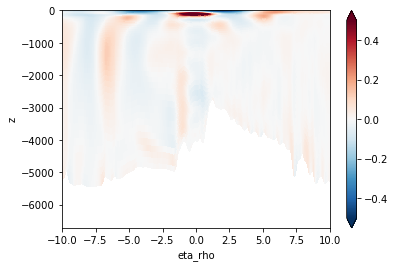

In [16]:
%%time
#plot slice longitude
longitude = -30.
vnew= slice(ds,u,z,longitude=longitude)
ax = vnew.plot(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],
         #xlim=[-10.,10.], ylim=[-1000.,0.],
          xlim=[-10.,10.], 
          vmin=-0.5, vmax=0.5, cmap = 'RdBu_r', facecolor='burlywood')
#ax = plt.gca()
#ax.set_facecolor('burlywood')

CPU times: user 3.41 s, sys: 190 ms, total: 3.6 s
Wall time: 3.4 s


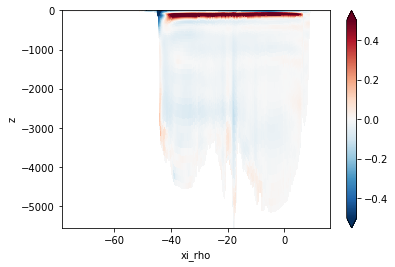

In [17]:
%%time
#plot slice latitude
latitude = 0.
vnew= slice(ds,u,z, latitude=latitude)
vnew.plot(x=[s for s in vnew.coords if s in ["xi_rho","xi_u","xi_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],
          vmin=-0.5, vmax=0.5, cmap = 'RdBu_r')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray (y_rho: 2002, x_rho: 1502)>
dask.array<mul, shape=(2002, 1502), dtype=float64, chunksize=(2002, 1502), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_rho   (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
    eta_w    (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.46343 65.42858
    xi_w     (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.078564 27.151964
    s_rho    (y_rho, x_rho) float64 -0.99 -0.99 -0.99 ... -0.99 -0.99 -0.99
Dimensions without coordinates: y_rho, x_rho
CPU times: user 9min 32s, sys: 3min 4s, total: 12min 37s
Wall time: 8min 52s


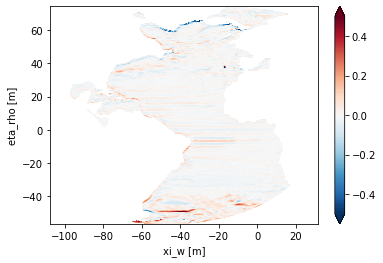

In [18]:
%%time
# plot slice depth
depth=-1000.
vnew= slice(ds,u,z,depth=depth)
print(vnew)
vnew.plot(x=[s for s in u.coords if "xi_" in s][0],
                       y=[s for s in u.coords if "eta_" in s][0],
                       vmin=-0.5, vmax=0.5, cmap='RdBu_r')

CPU times: user 331 ms, sys: 2.6 ms, total: 334 ms
Wall time: 312 ms


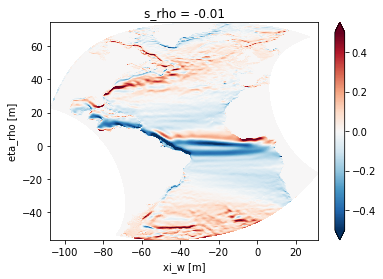

In [19]:
%%time
u.isel(s_rho=N-1).plot(x=[s for s in u.coords if "xi_" in s][0],
                       y=[s for s in u.coords if "eta_" in s][0],
                      vmin=-0.5, vmax=0.5, cmap='RdBu_r')

<xarray.DataArray 'v' (s_rho: 50, y_v: 2001, x_rho: 1502)>
dask.array<zarr, shape=(50, 2001, 1502), dtype=float32, chunksize=(1, 2001, 1502), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    eta_v    (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    xi_v     (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
Dimensions without coordinates: y_v, x_rho
CPU times: user 402 ms, sys: 33.6 ms, total: 436 ms
Wall time: 446 ms


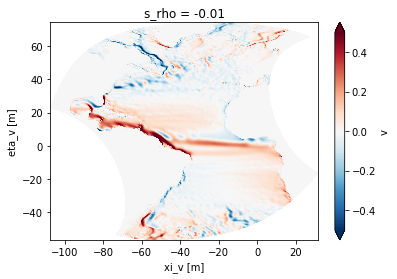

In [20]:
%%time
v = ds.v
print(v)
v.isel(s_rho=N-1).plot(x=[s for s in v.coords if "xi_" in s][0],
                       y=[s for s in v.coords if "eta_" in s][0],
                      vmin=-0.5, vmax=0.5, cmap='RdBu_r')

<xarray.DataArray 'rho' (s_rho: 50, y_rho: 2002, x_rho: 1502)>
dask.array<zarr, shape=(50, 2002, 1502), dtype=float32, chunksize=(1, 2002, 1502), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    eta_w    (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_w     (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
CPU times: user 452 ms, sys: 42.7 ms, total: 494 ms
Wall time: 392 ms


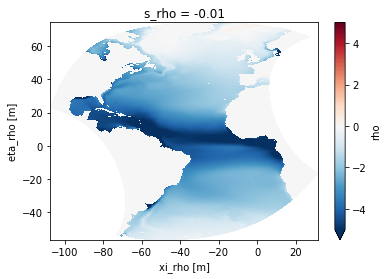

In [21]:
%%time
rho = ds.rho
print(rho)
rho.isel(s_rho=N-1).plot(x=[s for s in rho.coords if "xi_" in s][0],
                       y=[s for s in rho.coords if "eta_" in s][0],
                      vmin=-5, vmax=5, cmap='RdBu_r')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.DataArray (s_rho: 50, y_rho: 2002)>
dask.array<truediv, shape=(50, 2002), dtype=float32, chunksize=(50, 2002), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z        (s_rho, y_rho) float64 dask.array<chunksize=(1, 2002), meta=np.ndarray>
    eta_rho  (s_rho, y_rho) float32 dask.array<chunksize=(50, 2002), meta=np.ndarray>
Dimensions without coordinates: y_rho


/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3221: UserWarning: Large object of size 15.04 MB detected in task graph: 
  (array([[False, False, False, ..., False, False, F ... dtype=float32))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


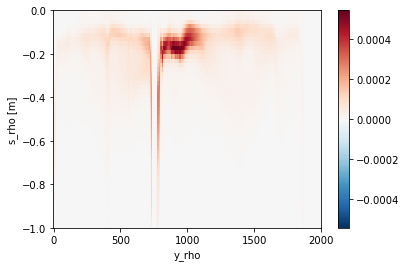

In [22]:
N2=ds.bvf
N2a=w2rho(N2,ds)
longitude = -35.
vnew= slice(ds,N2a,z,longitude=longitude)
print(vnew)
vnew.plot()

In [23]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", l